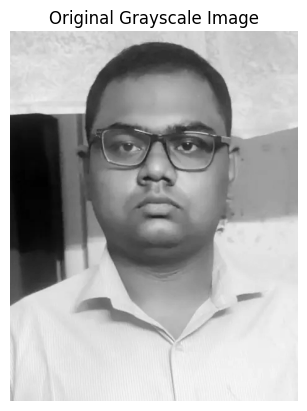

<ipython-input-26-771ffe171308>:46: RuntimeWarning: overflow encountered in scalar subtract
  black2 = ii[y + h -1, x + w -1] - (ii[y + h -1, x + half_w -1] if x + half_w > 0 else 0) - (ii[y + half_h -1, x + w -1] if y + half_h > 0 else 0) + (ii[y + half_h -1, x + half_w -1] if x + half_w > 0 and y + half_h > 0 else 0)
<ipython-input-26-771ffe171308>:46: RuntimeWarning: overflow encountered in scalar add
  black2 = ii[y + h -1, x + w -1] - (ii[y + h -1, x + half_w -1] if x + half_w > 0 else 0) - (ii[y + half_h -1, x + w -1] if y + half_h > 0 else 0) + (ii[y + half_h -1, x + half_w -1] if x + half_w > 0 and y + half_h > 0 else 0)
<ipython-input-26-771ffe171308>:45: RuntimeWarning: overflow encountered in scalar subtract
  white2 = ii[y + h -1, x + half_w -1] - (ii[y + h -1, x -1] if x > 0 else 0) - (ii[y + half_h -1, x + half_w -1] if y + half_h > 0 else 0) + (ii[y + half_h -1, x -1] if x > 0 and y + half_h > 0 else 0)
<ipython-input-26-771ffe171308>:45: RuntimeWarning: overflow encount

Face detected at (x=110, y=210, w=220, h=220)


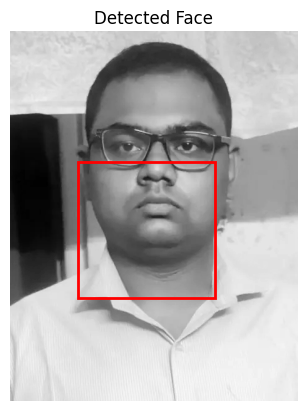

In [ ]:
import urllib.request
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

def load_image(url):
    with urllib.request.urlopen(url) as response:
        img_data = response.read()
    return Image.open(BytesIO(img_data))

def display_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def compute_integral_image(img):
    return img.cumsum(axis=0).cumsum(axis=1)

def get_region_sum(ii, x1, y1, x2, y2):
    A = ii[y1 - 1, x1 - 1] if x1 > 0 and y1 > 0 else 0
    B = ii[y1 - 1, x2] if y1 > 0 else 0
    C = ii[y2, x1 - 1] if x1 > 0 else 0
    D = ii[y2, x2]
    return D - B - C + A

def haar_feature(ii, x, y, w, h, feature_type):
    if feature_type == 'two_rect_horizontal' and w >= 2:
        half_w = w // 2
        white = get_region_sum(ii, x, y, x + half_w - 1, y + h - 1)
        black = get_region_sum(ii, x + half_w, y, x + w - 1, y + h - 1)
        return white - black
    elif feature_type == 'two_rect_vertical' and h >= 2:
        half_h = h // 2
        white = get_region_sum(ii, x, y, x + w - 1, y + half_h - 1)
        black = get_region_sum(ii, x, y + half_h, x + w - 1, y + h - 1)
        return white - black
    elif feature_type == 'three_rect_horizontal' and w >= 3:
        third_w = w // 3
        white1 = get_region_sum(ii, x, y, x + third_w - 1, y + h - 1)
        black = get_region_sum(ii, x + third_w, y, x + 2 * third_w - 1, y + h - 1)
        white2 = get_region_sum(ii, x + 2 * third_w, y, x + w - 1, y + h - 1)
        return white1 - black + white2
    elif feature_type == 'four_rect' and w >= 2 and h >= 2:
        half_w = w // 2
        half_h = h // 2
        white1 = get_region_sum(ii, x, y, x + half_w - 1, y + half_h - 1)
        black1 = get_region_sum(ii, x + half_w, y, x + w - 1, y + half_h - 1)
        white2 = get_region_sum(ii, x, y + half_h, x + half_w - 1, y + h - 1)
        black2 = get_region_sum(ii, x + half_w, y + half_h, x + w - 1, y + h - 1)
        return white1 - black1 + white2 - black2
    return 0

def detect_face(ii, scales, win_size, step, threshold):
    height, width = ii.shape
    max_value = -np.inf
    best_face = None
    feature_types = ['two_rect_horizontal', 'two_rect_vertical', 'three_rect_horizontal', 'four_rect']

    for scale in scales:
        scaled_w, scaled_h = int(win_size[0] * scale), int(win_size[1] * scale)
        if scaled_w > width or scaled_h > height:
            continue
        for y in range(0, height - scaled_h, step):
            for x in range(0, width - scaled_w, step):
                total = sum(haar_feature(ii, x, y, scaled_w, scaled_h, ft) for ft in feature_types)
                if total > max_value:
                    max_value, best_face = total, (x, y, scaled_w, scaled_h)

    if best_face and max_value > threshold:
        return best_face
    return None

def main():
    url = "https://raw.githubusercontent.com/saptarshihalder/Assignment-2/refs/heads/main/Image.png"
    image = load_image(url)
    gray_image = image.convert('L')
    gray_array = np.array(gray_image)

    display_image(gray_image, "Original Grayscale Image")

    integral_img = compute_integral_image(gray_array)

    face = detect_face(
        integral_img,
        scales=[1.0, 1.2, 1.5, 1.8, 2.0],
        win_size=(110, 110),
        step=5,
        threshold=200000
    )

    if face:
        x, y, w, h = face
        print(f"Face detected at (x={x}, y={y}, w={w}, h={h})")
        plt.imshow(gray_image, cmap='gray')
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
        plt.title("Detected Face")
        plt.axis('off')
        plt.show()
    else:
        print("No face detected.")

if __name__ == "__main__":
    main()
